# Generating and testing a classifier on adversarial samples

Based on https://medium.com/analytics-vidhya/implementing-adversarial-attacks-and-defenses-in-keras-tensorflow-2-0-cab6120c5715 by Sebastian Theiler

This is the first file!


##Imports and making sure we have tensorflow 2.0

In [1]:
!pip install tensorflow --upgrade

     |████████████████████████████████| 86.3MB 139kB/s 
     |████████████████████████████████| 450kB 41.2MB/s 
     |████████████████████████████████| 3.8MB 49.5MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.2 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

In [1]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Input, Conv1D,Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from tensorflow.keras.models import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
def train_with_augment(model, x_train, y_train, x_test, y_test, data_augmentation=True, nepochs=25, batch_size=256):
  if not data_augmentation:
      print('Not using data augmentation.')
      history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=nepochs,
              validation_data=(x_test, y_test),
              shuffle=True)
      acc = history.history['acc']
      val_acc = history.history['val_acc']
      loss = history.history['loss']
      val_loss = history.history['val_loss']
      epochs = range(1, len(acc) + 1)
      plt.plot(epochs, acc, 'bo', label='Training acc')
      plt.plot(epochs, val_acc, 'b', label='Validation acc')
      plt.title('Training and validation accuracy')
      plt.legend()
      plt.figure()
      plt.plot(epochs, loss, 'bo', label='Training loss')
      plt.plot(epochs, val_loss, 'b', label='Validation loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.show()

  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
      history = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=nepochs,
                        validation_data=(x_test, y_test),
                        workers=4)
      acc = history.history['acc']
      val_acc = history.history['val_acc']
      loss = history.history['loss']
      val_loss = history.history['val_loss']
      epochs = range(1, len(acc) + 1)
      plt.plot(epochs, acc, 'bo', label='Training acc')
      plt.plot(epochs, val_acc, 'b', label='Validation acc')
      plt.title('Training and validation accuracy')
      plt.legend()
      plt.figure()
      plt.plot(epochs, loss, 'bo', label='Training loss')
      plt.plot(epochs, val_loss, 'b', label='Validation loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.show()

  return model

def adversarial_pattern(image, label):
  image = tf.cast(image, tf.float32)
  
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.categorical_crossentropy(
              label,
              prediction,
              from_logits=False,
              label_smoothing=0)
    
  gradient = tape.gradient(loss, image)
  signed_grad = tf.sign(gradient)

  return signed_grad

def many_adv_samples(images, labels, epsilon=.1):
  adv_images = [_ for i in range(len(labels))]
  img_rows, img_cols, channels = images[0].shape
  for i in range(len(labels)):
    label = labels[i]
    image = images[i]
    perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
    adv_images[i] = image + perturbations * epsilon

  return adv_images

## Load Data and Prepare Model

### We'll use the CIFAR-10 dataset https://www.cs.toronto.edu/~kriz/cifar.html

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
# change per dataset
labels = ['airplane', 'automobile', 
               'bird', 'cat', 
               'deer', 'dog', 
               'frog', 'horse', 
               'ship', 'truck']

In [0]:
img_rows, img_cols, channels = 32, 32, 3
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
input_shape = x_train.shape[1:]
num_classes = y_train.shape[1]
print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 32, 32, 3) (10000, 10) (50000, 32, 32, 3) (50000, 10)


###VGG16 with some dense layers on the end as our sample classifier

In [0]:
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_vgg.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dense(num_classes, activation="softmax")(x)

In [0]:
model = Model(inputs=base_vgg.input, outputs=x)
opt = Adam(0.001)
model.summary();
model.save('untrained_classifier.hdf5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [0]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [0]:
model = train_with_augment(model, x_train, y_train, x_test, y_test)

In [0]:
model.save_weights('base_classifier_weights.hdf5')
model.save('base_classifier.hdf5')

In [0]:
model = load_model('base_classifier.hdf5')

Text(0.5, 1.05, 'Sample')

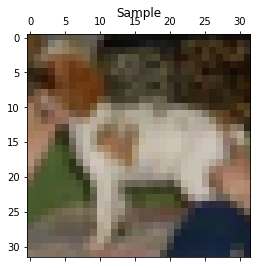

In [0]:
sample_index = 12
epsilon = .01
sample = x_test[sample_index]
sample_preds = model.predict(np.array([sample])).flatten()
sample_label = np.argmax(y_test[sample_index])
plt.matshow(sample)
plt.title('Sample')

Text(0.5, 1.0, 'Predictions for class dog')

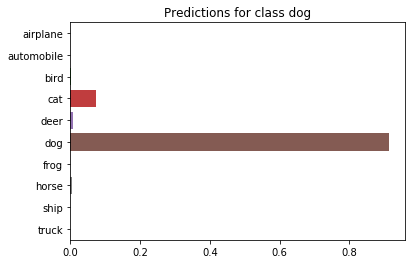

In [0]:
ax = sns.barplot(x=sample_preds, y=labels)
ax.set_title('Predictions for class ' + labels[sample_label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


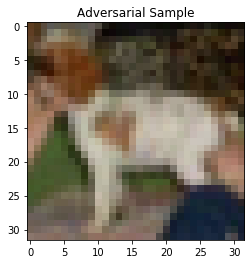

In [0]:
image = x_test[sample_index]
image_label = y_test[sample_index]
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
adv_sample = image + perturbations * epsilon
adv_preds = model.predict(adv_sample).flatten()
plt.imshow(adv_sample.reshape((img_rows, img_cols, channels)))
plt.title('Adversarial Sample')
plt.show()

Text(0.5, 1.0, 'Predictions for class dog')

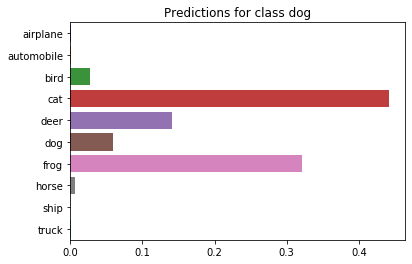

In [0]:
ax = sns.barplot(x=adv_preds, y=labels)
ax.set_title('Predictions for class ' + labels[sample_label])

### Test this model on adversarial samples

In [0]:
preds = model.predict([x_test])
normal_acc = np.mean(np.argmax(np.round(preds,0), axis=1) == np.argmax(y_test, axis=1))
print('normal accuracy: ', normal_acc,
      '\nnormal avg stddev: ', np.mean(np.std(preds, axis=1)))

normal accuracy:  0.8432 
normal avg stddev:  0.27324077


In [0]:
adv_samples = many_adv_samples(x_test,y_test, epsilon)
# reshape to be n x img_shape
adv_samples = np.array(adv_samples)
adv_samples = adv_samples.reshape((adv_samples.shape[0], adv_samples.shape[2], adv_samples.shape[3], adv_samples.shape[4]))

In [0]:
# many_adv_samples takes a while, so we'll save the array to disk to use it later
np.save('adv_samples.npy', adv_samples)

In [0]:
adv_samples = np.load('adv_samples.npy')

In [0]:
adv_preds = model.predict(adv_samples)
sample_labels = y_test

In [0]:
adv_acc = np.mean(np.argmax(np.round(adv_preds,0), axis=1) == np.argmax(y_test, axis=1))
print('adversarial accuracy: ', adv_acc, 
      '\nadversarial avg stddev: ', np.mean(np.std(adv_preds, axis=1)))

adversarial accuracy:  0.387 
adversarial avg stddev:  0.2538683
